<a href="https://colab.research.google.com/github/aarandjel/importance-sampling-with-feedforward-networks/blob/main/arithmetic_asian_basket_call_multivariate_correlated_Stein_Stein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importance sampling for option pricing with feedforward neural networks

In this Jupyter notebook, we study the problem of reducing the standard error in Monte Carlo simulations when pricing path-dependent options through suitable changes of measure which are induced by feedforward networks.

We consider an arithmetic Asian basket call option in a multivariate correlated Stein \& Stein model.

In [ ]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import norm
from tqdm.notebook import trange
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Concatenate, Subtract, Multiply, Lambda, Add, Dot, Reshape, Cropping1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

Python version:  3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow version:  2.6.0
Keras version:  2.6.0


In [ ]:
# pip install tensorflow==2.6.0 ### instead of 2.0.0

In [ ]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

In [ ]:
T = 1
N = 32
delta_t = T/N
strike = 60.0
r = 0.05
N_assets = 5
N_train = 3*10**5
learnrate = 0.001

In [ ]:
X_0 = np.around(np.random.uniform(low=40.0, high=50.0, size=(N_assets)),0)
V_0 = np.around(np.random.uniform(low=0.00, high=0.30, size=(N_assets)),4)

mu = np.around(np.random.uniform(low=0.0, high=0.05, size=(N_assets)),4)
m = 0.15 * np.ones((N_assets))

Theta = 10.0 * np.diag(np.ones((N_assets)))
# Theta = np.around(np.random.uniform(low=1.5, high=2.0, size=(N_assets, N_assets)), 2)

Sigma = 1.00 * np.diag(np.ones((2*N_assets)))
# Sigma = np.around(np.random.uniform(low=-0.25, high=0.25, size=(N_assets, N_assets)), 2)

Sigmaprime = np.dot(Sigma, Sigma)

weights = mu / (norm(Sigma[0:N_assets, 0:N_assets], axis=0))
weights = weights / np.sum(weights)

print(weights)

[0.21880342 0.03076923 0.25868946 0.25527066 0.23646724]


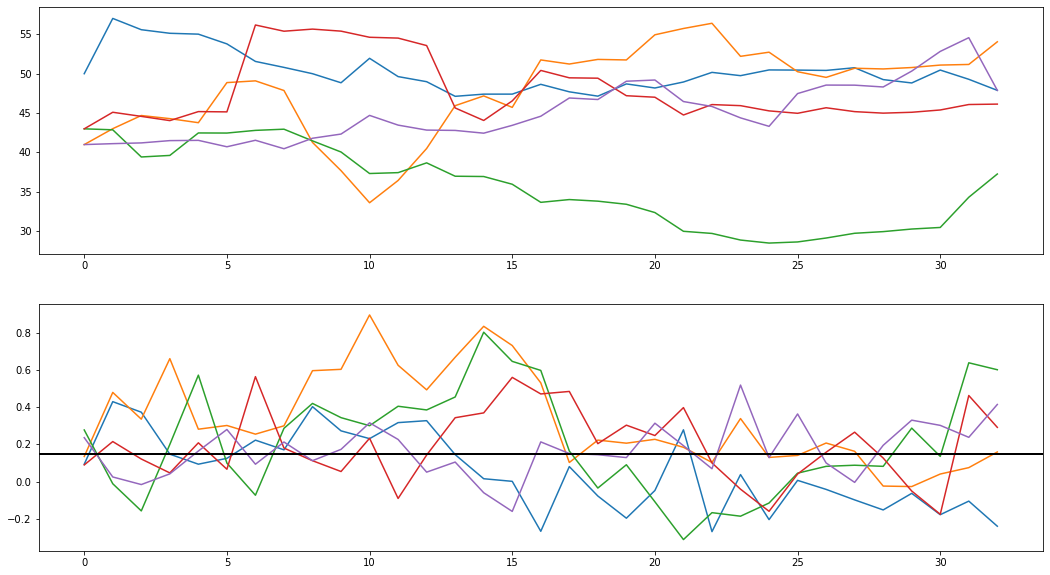

In [ ]:
X = [X_0]
X_dummy = X_0

V = [V_0]
V_dummy = V_0

for i in range(N):
    increment = np.random.normal(0, np.sqrt(delta_t), (2*N_assets))
    increment = np.dot(Sigma, increment)
    
    increment_X = increment[:N_assets]
    increment_V = increment[N_assets:]
    
    V_dummy = V_dummy + np.dot(Theta, m-V_dummy) * delta_t + increment_V
    V = V + [V_dummy]
    
    x1 = np.multiply(mu, V_dummy)
    x2 = np.multiply(V_dummy, X_dummy)
    drift = np.multiply(x1, x2) * delta_t
    
    # drift = np.multiply(mu, X_dummy) * delta_t
    diffusion = np.multiply(np.multiply(V_dummy, X_dummy), increment_X)
    
    X_dummy = X_dummy + drift + diffusion
    X = X + [X_dummy]

t = np.linspace(0, T, N+1) 

fig, axs = plt.subplots(2, figsize=(18, 10))

axs[0].plot(X)
axs[1].plot(V)
axs[1].axhline(0.15, color="black", linewidth=2)

plt.show()

In [ ]:
# NB: The price is quoted in cents

N_sample = 5000
outcomes = []
 
start_time = time.time()

for j in progressbar(range(N_sample), "Computing: ", 60):
    X = [X_0]
    X_dummy = X_0

    V = [V_0]
    V_dummy = V_0

    for i in range(N):
        increment = np.random.normal(0, np.sqrt(delta_t), (2*N_assets))
        increment = np.dot(Sigma, increment)
    
        increment_X = increment[:N_assets]
        increment_V = increment[N_assets:]
    
        V_dummy = V_dummy + np.dot(Theta, m-V_dummy) * delta_t + increment_V
        V = V + [V_dummy]
    
        x1 = np.multiply(mu, V_dummy)
        x2 = np.multiply(V_dummy, X_dummy)
        drift = np.multiply(x1, x2) * delta_t
        
        # drift = np.multiply(mu, X_dummy) * delta_t
        diffusion = np.multiply(np.multiply(V_dummy, X_dummy), increment_X)
    
        X_dummy = X_dummy + drift + diffusion
        X = X + [X_dummy]
        
    outcomes = outcomes + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(X, axis=0) * delta_t / T)) - strike, 0, None)]
    
elapsed_time = time.time() - start_time

mean_mc = np.mean(outcomes)
std_mc = np.std(outcomes)
stderr_mc = std_mc / np.sqrt(N_sample)
 
print("elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
 
print("Mean (MC): ", np.around(mean_mc, 4))
print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

Computing: [############################################################] 5000/5000
elapsed time:  00:00:12
Mean (MC):  0.0673
Standard error (MC):  0.0598  ( 88.81 % )


In [ ]:
def custom_activation(x):
    return 1.7159*K.tanh(2*x/3)

In [ ]:
layers = []
 
layer = Dense(2*N_assets, activation=custom_activation, trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.5), 
              bias_initializer=initializers.RandomNormal(0.0, 0.5), 
              name=str(0))
 
layers = layers + [layer]
 
layer = Dense(2*N_assets, activation="linear", trainable=True, 
              kernel_initializer=initializers.RandomNormal(0.0, 0.5), 
              bias_initializer=initializers.RandomNormal(0.0, 0.5), 
              name=str(4))
 
layers = layers + [layer]

In [ ]:
xtrain = ([np.zeros((N_train))] + # t_0
          [np.tile(mu, (N_train, 1))] + # mu
          [delta_t*np.ones((N_train, N_assets))] + # time increment
          [0*np.ones((N_train, 2*N_assets))] + # B_0
          [np.tile(X_0, (N_train, 1))] + # X_0
          [np.tile(V_0, (N_train, 1))] + # V_0
          [np.tile(weights / T, (N_train, 1))] + # wght
          [np.zeros((N_train, N_assets))] + # initial value of the payoff
          [np.zeros((N_train, 2*N_assets))] + # initial value of the first part of the stoch exp
          [np.zeros((N_train, 2*N_assets))] + # initial value of the second part of the stoch exp
          [np.random.normal(0,np.sqrt(delta_t),(N_train, 2*N_assets)) for i in range(N)]) # Brownian increments
 
ytrain = np.zeros((N_train))

In [ ]:
########## CURRENTLY HERE WITH THE REVISION
# https://stackoverflow.com/questions/38235555/tensorflow-matmul-of-input-matrix-with-batch-data

In [ ]:
t_0 = Input(shape=(1, ))
drft = Input(shape=(N_assets, ))
d_t = Input(shape=(N_assets, ))
 
B_0 = Input(shape=(2*N_assets, ))
X_start = Input(shape=(N_assets, ))
V_start = Input(shape=(N_assets, ))
 
wght = Input(shape=(N_assets, ))
 
c_0 = Input(shape=(N_assets, ))
c_1 = Input(shape=(2*N_assets, ))
c_2 = Input(shape=(2*N_assets, ))
 
inputs = [t_0]+[drft]+[d_t]+[B_0]+[X_start]+[V_start]+[wght]+[c_0]+[c_1]+[c_2]
 
t_current = t_0
B_current = B_0
# M_current = K.dot(B_current, K.constant(Sigma))
M_current = B_current @ tf.linalg.matrix_transpose(K.constant(Sigma))

X_current = X_start
V_current = V_start
 
for j in range(N):
    
    strategy = t_current
    strategy = layers[0](strategy)
    strategy = layers[1](strategy)
    
    incr_B = Input(shape=(2*N_assets, ))
    inputs = inputs + [incr_B]
    
    # incr_M = K.dot(incr_B, K.constant(Sigma))
    incr_M = incr_B @ tf.linalg.matrix_transpose(K.constant(Sigma))
    M_current = Add()([M_current, incr_M])
    
    ### Split up the increments
    first_half, second_half = tf.split(incr_M, 2, axis = 1)

    ### Compute V_current
    helper_v0 = Lambda(lambda x: m-x)(V_current)
    #helper_v1 = K.dot(helper_v0, K.constant(Theta))
    helper_v1 = helper_v0 @ tf.linalg.matrix_transpose(K.constant(Theta))
    helper_v2 = Lambda(lambda x: x*delta_t)(helper_v1)
    helper_v3 = Add()([helper_v2, second_half])
    V_current = Add()([V_current, helper_v3])
    
    ### Compute X_current
    helper_x0 = Multiply()([drft, V_current])
    helper_x1 = Multiply()([helper_x0, V_current])
    helper_x2 = Multiply()([helper_x1, X_current])
    helper_x3 = Lambda(lambda x: x*delta_t)(helper_x2)
    #helper_x0 = Multiply()([drft, X_current])
    #helper_x3 = Lambda(lambda x: x*delta_t)(helper_x0)
    
    helper_x4 = Multiply()([V_current, X_current])
    helper_x5 = Multiply()([helper_x4, first_half])
    
    helper_x6 = Add()([helper_x3, helper_x5])
    X_current = Add()([X_current, helper_x6])
    
    ### Compute part of payoff
    helper_6 = Multiply()([X_current, d_t])
    helper_7 = Multiply()([wght, helper_6])
    c_0 = Add()([c_0, helper_7])
    
    ### Compute c_1 summand
    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    ### Compute c_2 summand
    ##### helper_e2 = K.dot(strategy, K.constant(Sigmaprime))
    #helper_e2 = strategy @ tf.linalg.matrix_transpose(K.constant(Sigmaprime))
    #helper_e3 = K.dot(helper_e2, tf.transpose(strategy))
    helper_e3 = Multiply()([strategy, strategy])
    # helper_e3 = tf.linalg.matrix_transpose(strategy) @ helper_e2
    helper_e4 = Lambda(lambda x: x*delta_t)(helper_e3)
    c_2 = Add()([c_2, helper_e4])
       
    t_current = Lambda(lambda x: x + delta_t)(t_current)
    
helper_y1 = Lambda(lambda x: -0.5 * K.sum(x, axis=1))(c_1)
helper_y2 = Lambda(lambda x: 0.25 * K.sum(x, axis=1))(c_2)
 
helper_y3 = Add()([helper_y1, helper_y2])
helper_y4 = Lambda(lambda x: K.exp(x))(helper_y3)
 
c_0 = Lambda(lambda x: K.sum(x, axis=1))(c_0)
c_0 = Lambda(lambda x: K.relu(x - strike))(c_0)
 
c_0 = Multiply()([c_0, helper_y4])
 
outputs = [c_0]

In [ ]:
def custom_loss(y_true,y_pred):
    z = K.mean(K.square(y_pred))
    return z
 
adam = optimizers.Adam(learning_rate=learnrate)
 
model = Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer=adam,loss=custom_loss)
model.compile(optimizer=adam, loss="mean_squared_error", metrics=["mse"])

# model.summary()

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.00001)

In [ ]:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights=True)
model.fit(x=xtrain, y=ytrain, epochs=25, verbose = 1, batch_size=512, validation_split=0.2, callbacks=[es])

Epoch 1/25
469/469 [==============================] - 5s 11ms/step - loss: 6.9842e-04 - mse: 6.9805e-04 - val_loss: 7.8095e-04 - val_mse: 7.7558e-04
Epoch 2/25
469/469 [==============================] - 5s 11ms/step - loss: 6.9780e-04 - mse: 6.9743e-04 - val_loss: 7.8140e-04 - val_mse: 7.7602e-04
Epoch 3/25
469/469 [==============================] - 5s 11ms/step - loss: 6.9700e-04 - mse: 6.9894e-04 - val_loss: 7.8281e-04 - val_mse: 7.7742e-04
Epoch 4/25
469/469 [==============================] - 5s 11ms/step - loss: 6.9630e-04 - mse: 6.9593e-04 - val_loss: 7.8440e-04 - val_mse: 7.7900e-04
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [ ]:
# model.summary()

for i in range(600):
    print(i)
    print(model.layers[i].get_weights())

0
[]
1
[]
2
[]
3
[]
4
[]
5
[]
6
[]
7
[]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[]
23
[]
24
[]
25
[]
26
[]
27
[]
28
[]
29
[]
30
[]
31
[]
32
[]
33
[]
34
[]
35
[]
36
[]
37
[]
38
[]
39
[]
40
[]
41
[]
42
[]
43
[]
44
[]
45
[]
46
[]
47
[]
48
[]
49
[]
50
[]
51
[]
52
[]
53
[]
54
[]
55
[]
56
[]
57
[]
58
[]
59
[]
60
[]
61
[]
62
[]
63
[]
64
[]
65
[]
66
[]
67
[]
68
[]
69
[]
70
[]
71
[]
72
[]
73
[]
74
[]
75
[]
76
[]
77
[]
78
[]
79
[]
80
[]
81
[]
82
[]
83
[]
84
[]
85
[]
86
[]
87
[]
88
[]
89
[]
90
[]
91
[]
92
[]
93
[]
94
[]
95
[]
96
[]
97
[]
98
[]
99
[]
100
[]
101
[]
102
[]
103
[]
104
[]
105
[]
106
[]
107
[]
108
[]
109
[]
110
[]
111
[]
112
[]
113
[]
114
[]
115
[]
116
[]
117
[]
118
[]
119
[]
120
[]
121
[]
122
[]
123
[]
124
[]
125
[]
126
[]
127
[]
128
[]
129
[]
130
[]
131
[]
132
[]
133
[]
134
[]
135
[]
136
[]
137
[]
138
[]
139
[]
140
[]
141
[]
142
[]
143
[]
144
[]
145
[]
146
[]
147
[]
148
[]
149
[]
150
[]
151
[]
152
[]
153
[]
154
[]
155
[]
156
[]
157
[]
158


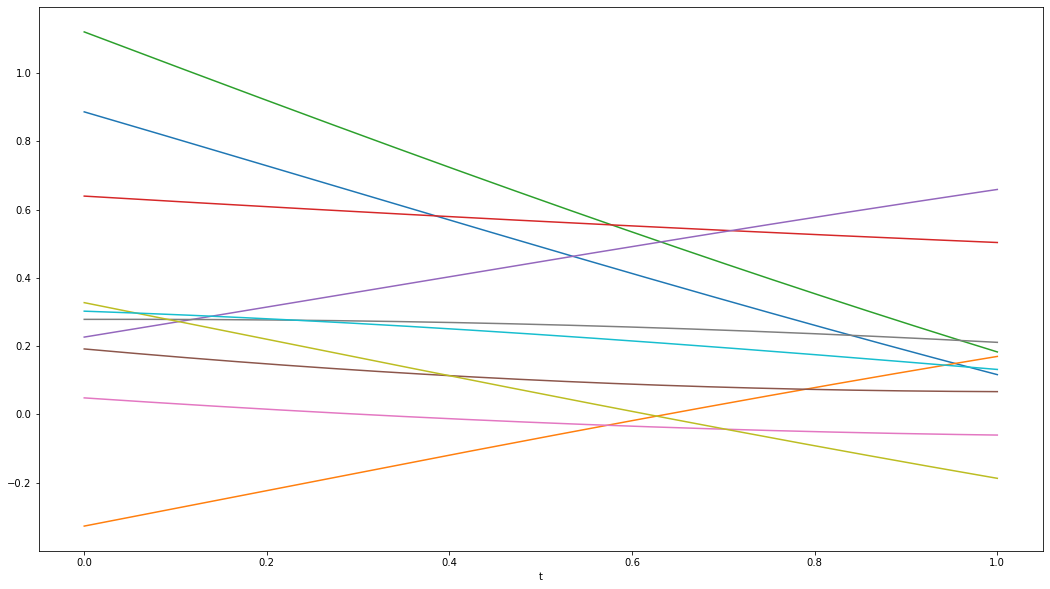

In [ ]:
N = 252
delta_t = T/N
 
model_test = keras.Sequential()
model_test.add(Dense(2*N_assets, activation=custom_activation, name="layer1", input_shape=(1, )))
model_test.add(Dense(2*N_assets, activation="linear", name="layer5"))
 
model_test.build()
 
model_test.layers[0].set_weights(model.layers[410].get_weights())
model_test.layers[1].set_weights(model.layers[415].get_weights())
 
t = np.linspace(0, T, N+1)
learnedstrat = model_test.predict(t)
 
plt.figure(figsize=(18, 10))
plt.plot(t, learnedstrat)
plt.xlabel("t")
plt.show()

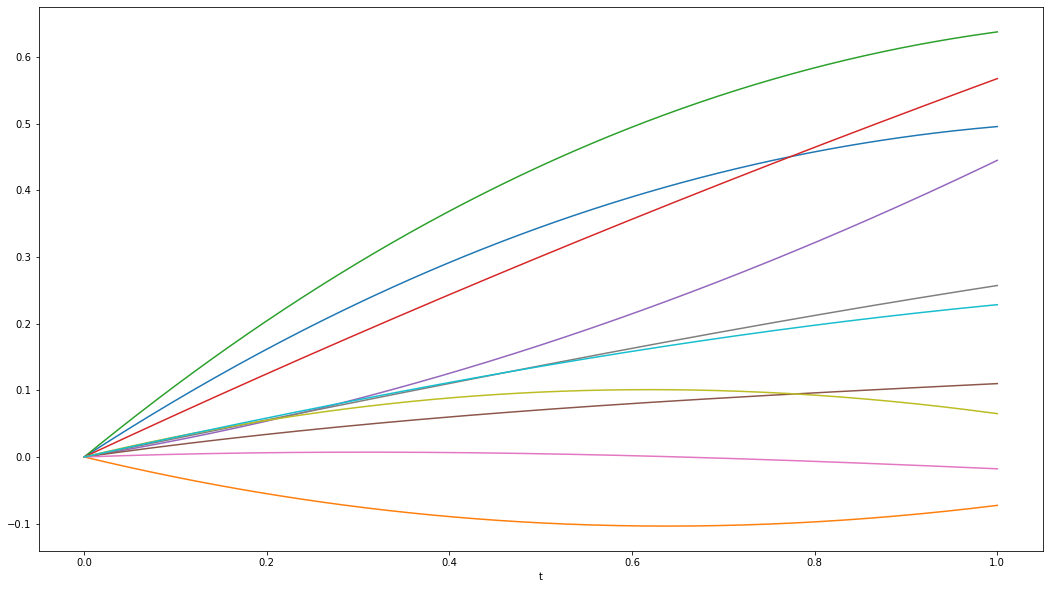

In [ ]:
normdrift = 0
driftdelta = []
driftcomponent = [0*np.ones((2*N_assets,))]

driftdummy = 0*np.ones((2*N_assets,))

for i in range(N):
    normdrift = normdrift + np.dot(np.transpose(learnedstrat[i,:]), np.dot(Sigmaprime, learnedstrat[i,:]))*delta_t
    
# print(normcomponent)

for i in range(N):
    driftdummy = driftdummy + np.transpose(np.dot(Sigmaprime, learnedstrat[i,:]))*delta_t
    driftcomponent = driftcomponent + [driftdummy]
    
for i in range(N):
    driftdelta = driftdelta + [np.transpose(np.dot(Sigmaprime, learnedstrat[i,:]))*delta_t]

plt.figure(figsize=(18, 10))
plt.plot(t, driftcomponent)
plt.xlabel("t")
plt.show()

In [ ]:
N_sample = 5000
outcomes_MC = []
outcomes_IS = []
 
start_time = time.time()

for j in progressbar(range(N_sample), "Computing: ", 60):

    X_MC = [X_0]
    X_dummy_MC = X_0

    V_MC = [V_0]
    V_dummy_MC = V_0
    
    X_IS = [X_0]
    X_dummy_IS = X_0

    V_IS = [V_0]
    V_dummy_IS = V_0

    C0 = 0
    C1 = normdrift

    for i in range(N):
        increment = np.random.normal(0, np.sqrt(delta_t), (2*N_assets))
        increment = np.dot(Sigma, increment)
        increment_IS = increment + driftdelta[i]
        
        ############### MC
        increment_X_MC = increment[:N_assets]
        increment_V_MC = increment[N_assets:]
    
        V_dummy_MC = V_dummy_MC + np.dot(Theta, m-V_dummy_MC)*delta_t + increment_V_MC
        V_MC = V_MC + [V_dummy_MC]
    
        #x1 = np.multiply(mu, V_dummy_MC)
        #x2 = np.multiply(V_dummy_MC, X_dummy_MC)
        #drift = np.multiply(x1, x2)*delta_t
        
        drift = np.multiply(mu, X_dummy_MC) * delta_t
        diffusion = np.multiply(np.multiply(V_dummy_MC, X_dummy_MC), increment_X_MC)
    
        X_dummy_MC = X_dummy_MC + drift + diffusion
        X_MC = X_MC + [X_dummy_MC]
        
        ############### IS
    
        increment_X_IS = increment_IS[:N_assets]
        increment_V_IS = increment_IS[N_assets:]
    
        V_dummy_IS = V_dummy_IS + np.dot(Theta, m-V_dummy_IS)*delta_t + increment_V_IS
        V_IS = V_IS + [V_dummy_IS]
    
        #x1 = np.multiply(mu, V_dummy_IS)
        #x2 = np.multiply(V_dummy_IS, X_dummy_IS)
        #drift = np.multiply(x1, x2)*delta_t
        
        drift = np.multiply(mu, X_dummy_IS) * delta_t
        diffusion = np.multiply(np.multiply(V_dummy_IS, X_dummy_IS), increment_X_IS)
    
        X_dummy_IS = X_dummy_IS + drift + diffusion
        X_IS = X_IS + [X_dummy_IS]
    
        C0 = C0 - np.dot(learnedstrat[i,:], increment)
    
    adjustment = np.exp(C0 - 0.5 * C1)

    outcomes_MC = outcomes_MC + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(X_MC, axis=0) * delta_t / T)) - strike, 0, None)]
    outcomes_IS = outcomes_IS + [np.exp(-r*T) * 100 * np.clip(np.sum(np.multiply(weights, np.sum(X_IS, axis=0) * delta_t / T)) - strike, 0, None) * adjustment]
    
###############

mean_MC = np.mean(outcomes_MC)
mean_IS = np.mean(outcomes_IS)

stderr_MC = np.std(outcomes_MC) / np.sqrt(N_sample)
stderr_IS = np.std(outcomes_IS) / np.sqrt(N_sample)

varratio = np.var(outcomes_MC) / np.var(outcomes_IS)
    
elapsed_time = time.time() - start_time
print("total elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

###############
    
print("Mean (MC): ", np.around(mean_MC, 4))
print("Mean (IS): ", np.around(mean_IS, 4))
print("Standard error (MC): ", np.around(stderr_MC, 4), " (", np.around(stderr_MC / mean_MC * 100, 2), "% )")
print("Standard error (IS): ", np.around(stderr_IS, 4), " (", np.around(stderr_IS / mean_IS * 100, 2), "% )")
print("Variance ratio: ", np.around(varratio))

Computing: [############################################################] 5000/5000
total elapsed time:  00:01:03
Mean (MC):  0.0285
Mean (IS):  0.0394
Standard error (MC):  0.0232  ( 81.33 % )
Standard error (IS):  0.0115  ( 29.1 % )
Variance ratio:  4.0


In [ ]:
print("mean MC estimate:  ", np.around(np.mean(means_MC), 4))
print("mean IS estimate: ", np.around(np.mean(means_IS), 4))
 
bins = np.linspace(0.00, 2.50, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(means_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(means_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(means_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(means_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
print("mean MC estimate standard error:  ", np.around(np.mean(stderr_MC), 4))
print("mean IS estimate standard error: ", np.around(np.mean(stderr_IS), 4))
 
bins = np.linspace(0.00, 1.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(stderr_MC, bins, color="darkorchid", alpha=0.5, label="MC estimates")
plt.hist(stderr_IS, bins, color="goldenrod", alpha=0.5, label="IS estimates")
plt.axvline(np.mean(stderr_MC), color="darkorchid", linewidth=2)
plt.axvline(np.mean(stderr_IS), color="goldenrod", linewidth=2)
plt.title("MC estimates standard errors with and without importance sampling (sample size = 5000)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
bins = np.linspace(0.00, 150.00, 100)
 
plt.figure(figsize=(18, 10)) 
plt.hist(varratio, bins, color="darkorchid", alpha=0.5)
plt.title("Variance ratios (sample size = 5000)")
plt.show()

In [ ]:
data = {'mean MC': means_MC,
        'mean IS': means_IS,
        'stderr MC': stderr_MC,
        'stderr IS': stderr_IS, 
        'varratio': varratio}
 
df = pd.DataFrame(data, columns = ['mean MC','mean IS', 'stderr MC', 'stderr IS', 'varratio'])
df = df.sort_values(by=['varratio'])
 
print(df.tail(15))